In [1]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

from scipy import stats

# Unzip NASLib/run/results/xgb_correlation.zip before running the code

In [2]:
BENCHMARKS = {
#     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

START_SEED=9000
END_SEED=9005

def get_all_files(root_folder='../run/results/xgb_correlation', filename='scores.json'):
    all_files = []
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            if file.endswith(filename):
                #print(os.path.join(root, file))
                all_files.append(os.path.join(root, file))

    return all_files

def get_scores_as_list_of_dict(files):
    data = []

    for file in files:
        file_components = file.split('/')
        search_space, dataset, train_size, seed = file_components[-5], file_components[-4], file_components[-3], file_components[-2]

        with open(file, 'r') as f:
            info = json.load(f)

        config, scores = info[0], info[1]

        record = {
            'search_space': search_space,
            'dataset': dataset,
            'train_size': train_size,
            'seed': seed,
            'kendalltau': scores['kendalltau'],
            'pearson': scores['pearson'],
            'spearman': scores['spearman'],
            'preds': scores['full_testpred'],
            'ground_truth': scores['full_ytest'],
        }

        zc_names = config['zc_names']
        feature_importances = scores['zc_feature_importances']
        for zc_name in zc_names:
            record[f'{zc_name}_feat_imp'] = feature_importances[zc_name]

        data.append(record)

    return data

def plot_heatmap(df, figsize=(18, 6), rotation=0, title=''):
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    heatmap = sns.heatmap(df, annot=True, cmap='viridis')
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=rotation)
    
    
def plot_heatmap_for_benchmark(df, search_space, dataset, corr_type):
    _df = df[(df['search_space'] == search_space) & (df['dataset'] == dataset)][['train_size', 'seed', corr_type]]

#     print('BEFORE PIVOT')
#     print(_df)
#     print('___')
    
    pivot_df = _df.pivot_table(corr_type, 'seed', 'train_size')
    pivot_df.columns = pivot_df.columns.astype(int)
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)
    
    print('PIVOT TABLE')
    print(pivot_df)
    print('___')

    plot_heatmap(pivot_df.corr(), title=f'Correlation between rank correlations for {search_space}-{dataset}')

def compute_correlation(df, predictors):
    corr = np.zeros((len(predictors), len(predictors)))
    for i in range(len(predictors)):
        for j in range(len(predictors)):
            zc_1 = predictors[i]
            zc_2 = predictors[j]

            preds_1 = np.array(df[df['train_size'] == zc_1]['preds'].to_list()[0])
            preds_2 = np.array(df[df['train_size'] == zc_2]['preds'].to_list()[0])
            coeff = np.corrcoef(preds_1, preds_2)[0, 1]
                
            #print(preds_1.shape, preds_2.shape, coeff)
            corr[i, j] = coeff

    return corr

def plot_correlation_between_zcs(df, search_space, dataset):
    all_corrs = []
    for seed in [str(i) for i in range(START_SEED, END_SEED)]:
    
        df_ = df[(df['search_space'] == search_space) & (df['seed'] == seed) & (df['dataset'] == dataset)]
        train_sizes = tuple(df_['train_size'].to_list()) # List of predictor names

        all_corrs.append(compute_correlation(df_, train_sizes))

    corr = np.mean(np.array(all_corrs), axis=0)
    corr_df = pd.DataFrame(corr)

    train_sizes_map = {i: train_sizes[i] for i in range(len(train_sizes))}
    corr_df = corr_df.rename(columns=train_sizes_map, index=train_sizes_map)
    plot_heatmap(corr_df, title=f'ZC Correlation for {search_space}-{dataset}')
    
def show_seeds(df, search_space):
    return df[df['search_space'] == search_space].groupby(['search_space', 'dataset', 'train_size'])['seed'].agg(['unique'])

def make_df(files):
    data = get_scores_as_list_of_dict(files)
    df = pd.DataFrame(data)
    return df

def make_search_space_train_size_df(df, metric, benchmarks):
    pred_scores = df.groupby(['search_space', 'dataset', 'train_size'])[metric].mean()
    
    series = []
    for searchspace, datasets in benchmarks.items():
        for dataset in datasets:
            if searchspace in pred_scores and dataset in pred_scores[searchspace]:
                series.append(pred_scores[searchspace][dataset].rename(f'{LABELS[searchspace]}-{LABELS[dataset]}'))

    # Concatenate all the series from left to right to get the dataframe
    # with datasets as the columns and 
    idf = series[0].to_frame()

    for idx, s in enumerate(series):
        if idx == 0:
            continue

        idf = idf.merge(s, left_index=True, right_index=True)

    return idf

with open('../run/correlation/nasbench201/cifar10/jacov/9001/scores.json', 'r') as f:
    data = json.load(f)


In [3]:
files = get_all_files()
len(files), files

(180,
 ['../run/results/xgb_correlation/transbench101_micro/jigsaw/400/9009/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/jigsaw/400/9007/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/jigsaw/400/9000/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/jigsaw/400/9001/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/jigsaw/400/9006/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/jigsaw/400/9008/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/jigsaw/400/9003/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/jigsaw/400/9004/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/jigsaw/400/9005/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/jigsaw/400/9002/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/autoencoder/400/9009/scores.json',
  '../run/results/xgb_correlation/transbench101_micro/autoencoder

In [4]:
df = make_df(files)
df

,search_space,dataset,train_size,seed,kendalltau,pearson,spearman,preds,ground_truth,flops_feat_imp,...,snip_feat_imp,jacov_feat_imp,grad_norm_feat_imp,plain_feat_imp,fisher_feat_imp,grasp_feat_imp,l2_norm_feat_imp,nwot_feat_imp,epe_nas_feat_imp,synflow_feat_imp
0,transbench101_micro,jigsaw,400,9009,0.661000,0.967471,0.839007,"[90.95958709716797, 92.83131408691406, 86.0727...","[89.6496810913086, 91.09275817871094, 91.78941...",272.0,...,141.0,360.0,199.0,306.0,539.0,275.0,231.0,272.0,NaN,NaN
1,transbench101_micro,jigsaw,400,9007,0.623834,0.978197,0.797015,"[0.10721588134765625, 92.87464904785156, 88.08...","[0.13933120667934418, 90.50557708740234, 84.84...",284.0,...,162.0,299.0,179.0,356.0,504.0,292.0,255.0,256.0,NaN,NaN
2,transbench101_micro,jigsaw,400,9000,0.605048,0.975999,0.776259,"[64.1664047241211, 92.74834442138672, 92.56098...","[69.05354309082031, 94.12320709228516, 92.1825...",267.0,...,138.0,359.0,161.0,332.0,530.0,292.0,220.0,226.0,NaN,NaN
3,transbench101_micro,jigsaw,400,9001,0.564504,0.945214,0.745245,"[88.3889389038086, 91.31387329101562, 89.44728...","[93.33698272705078, 92.97870635986328, 75.3682...",264.0,...,102.0,334.0,181.0,275.0,557.0,326.0,237.0,219.0,NaN,NaN
4,transbench101_micro,jigsaw,400,9006,0.630835,0.886252,0.809849,"[83.81847381591797, 92.74856567382812, 89.2939...","[91.68988800048828, 93.40167236328125, 91.6251...",282.0,...,143.0,331.0,178.0,303.0,516.0,292.0,194.0,226.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,transbench101_macro,class_object,400,9008,0.660767,0.852713,0.849181,"[45.34798049926758, 45.390071868896484, 45.567...","[45.78025436401367, 44.854698181152344, 43.944...",427.0,...,222.0,387.0,334.0,355.0,718.0,312.0,229.0,323.0,NaN,NaN
176,transbench101_macro,class_object,400,9003,0.686206,0.874802,0.875857,"[44.945777893066406, 45.82533264160156, 42.801...","[44.13813781738281, 45.591163635253906, 43.307...",448.0,...,186.0,432.0,309.0,363.0,721.0,320.0,276.0,240.0,NaN,NaN
177,transbench101_macro,class_object,400,9004,0.675681,0.872680,0.864734,"[43.07587432861328, 43.460113525390625, 45.281...","[41.4908447265625, 42.3964958190918, 45.198051...",448.0,...,168.0,430.0,290.0,398.0,650.0,320.0,254.0,270.0,NaN,NaN
178,transbench101_macro,class_object,400,9005,0.652155,0.852801,0.849034,"[45.35295867919922, 45.10277557373047, 44.4774...","[45.491641998291016, 44.22273254394531, 46.571...",484.0,...,212.0,406.0,342.0,406.0,681.0,353.0,260.0,290.0,NaN,NaN


In [5]:
# Sanity check to see all the seeds are there for all the predictors
show_seeds(df, 'transbench101_macro')

unique
search_space        dataset         train_size                                                   
transbench101_macro autoencoder     400         [9009, 9007, 9000, 9001, 9006, 9008, 9003, 900...
                    class_object    400         [9009, 9007, 9000, 9001, 9006, 9008, 9003, 900...
                    class_scene     400         [9009, 9007, 9000, 9001, 9006, 9008, 9003, 900...
                    jigsaw          400         [9009, 9007, 9000, 9001, 9006, 9008, 9003, 900...
                    normal          400         [9009, 9007, 9000, 9001, 9006, 9008, 9003, 900...
                    room_layout     400         [9009, 9007, 9000, 9001, 9006, 9008, 9003, 900...
                    segmentsemantic 400         [9009, 9007, 9000, 9001, 9006, 9008, 9003, 900...

In [6]:
# pred_df = make_search_space_train_size_df(df, 'spearman', BENCHMARKS)

# plot_heatmap(pred_df, figsize=(18, 6), rotation=0, title='Predictors vs ground truth correlation across benchmarks')
# plot_heatmap(pred_df.corr(), figsize=(18, 6), rotation=0, title='Correlation between benchmarks')

# plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench201', 'cifar100', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench201', 'ImageNet16-120', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench301', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'nasbench101', 'cifar10', 'spearman')
# plot_heatmap_for_benchmark(df, 'transbench101_micro', 'jigsaw', 'spearman')
# pred_df

In [7]:
def get_metrics(df, search_space, dataset, train_size, metric):
    df_ = df[(df['search_space'] == search_space) & (df['train_size'] == str(train_size)) & (df['dataset'] == dataset)]
    return df_[metric].tolist()

def get_metrics_as_np_arrays(df, search_space, dataset, train_sizes, metric):
    results = []

    for train_size in train_sizes:
        results.append(get_metrics(df, search_space, dataset, train_size, metric))

    results = np.array(results)
    means = np.mean(results, axis=1)
    stds = np.std(results, axis=1)
    
    return means, stds

def plot_line_chart(x_labels, means, stds, color, title='', ylabel=''):
    figsize=(16, 8)
    plt.figure(figsize=figsize, dpi=200)
    plt.title(title, fontsize=20)
    plt.plot(x_labels, means, color=color)
    plt.fill_between(x_labels, means + stds, means - stds, color=color, alpha=0.2)
    plt.xscale('log', base=10)
    plt.xlabel('Train size')
    plt.ylabel(ylabel)

def plot_train_sizes_vs_metric(df, search_space, dataset, train_sizes, metric, color='gray'):
    means, stds = get_metrics_as_np_arrays(df, search_space, dataset, train_sizes, metric)
    plot_line_chart(train_sizes, means, stds, color, title=f'{search_space}-{dataset}', ylabel=f'{metric} coefficient')


In [8]:
# train_sizes = [10, 16, 27, 46, 77, 129, 215, 359, 599]
# train_sizes = [10, 15, 23, 36, 56, 87, 135, 209, 323, 500]
train_sizes = [400]

# df = make_df(files)
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar10', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes, 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes, 'kendalltau', color='green')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes, 'kendalltau', color='blue')

In [9]:
def get_mean_grouped_by(df, search_space, dataset, train_size):
    df_ = df[(df['search_space'] == search_space) & (df['train_size'] == train_size) & (df['dataset'] == dataset)]
    return df_.groupby(['search_space', 'dataset', 'train_size'], as_index=False).mean()

def get_averaged_df(df, search_space, train_sizes):
    dfs = []

    for dataset in BENCHMARKS[search_space]:
        for train_size in train_sizes:
            dfs.append(get_mean_grouped_by(df, search_space, dataset, str(train_size)))
    
    return pd.concat(dfs)

def get_feature_importance_df(df, search_space, train_size):
    avg_df = get_averaged_df(df, search_space, train_sizes)
    feat_imp_cols = [c for c in avg_df.columns if c.endswith('_feat_imp')]
    avg_df = avg_df[avg_df['train_size'] == train_size].set_index('dataset')[feat_imp_cols]
    return avg_df

def plot_feature_importance_heatmap(df, search_space, train_size):
    avg_df = get_feature_importance_df(df, search_space, str(train_size))
    
    if search_space == 'transbench101_micro' or search_space == 'transbench101_macro':
        avg_df = avg_df.drop(columns=['epe_nas_feat_imp', 'synflow_feat_imp'])
    plot_heatmap(avg_df, rotation=45, title=f'{search_space}. Train size: {train_size}')

In [10]:
avg_df = get_averaged_df(df, 'nasbench201', train_sizes)
avg_df

,search_space,dataset,train_size,kendalltau,pearson,spearman,flops_feat_imp,params_feat_imp,snip_feat_imp,jacov_feat_imp,grad_norm_feat_imp,plain_feat_imp,fisher_feat_imp,grasp_feat_imp,l2_norm_feat_imp,nwot_feat_imp,epe_nas_feat_imp,synflow_feat_imp
0,nasbench201,cifar10,400,0.794351,0.900577,0.941357,177.9,1.8,138.1,248.8,191.2,226.5,314.8,234.2,193.4,187.5,483.4,229.0
0,nasbench201,cifar100,400,0.794313,0.928693,0.939430,194.8,1.0,133.6,282.1,198.0,241.1,314.1,214.3,206.8,169.0,514.3,242.0
0,nasbench201,ImageNet16-120,400,0.787645,0.930469,0.930883,224.7,1.9,130.6,294.4,180.9,268.7,350.7,229.6,222.3,209.1,543.5,246.1


In [11]:
feat_imp_cols = [c for c in avg_df.columns if c.endswith('_feat_imp')]
feat_imp_cols

['flops_feat_imp',
 'params_feat_imp',
 'snip_feat_imp',
 'jacov_feat_imp',
 'grad_norm_feat_imp',
 'plain_feat_imp',
 'fisher_feat_imp',
 'grasp_feat_imp',
 'l2_norm_feat_imp',
 'nwot_feat_imp',
 'epe_nas_feat_imp',
 'synflow_feat_imp']

In [12]:
df = make_df(files)

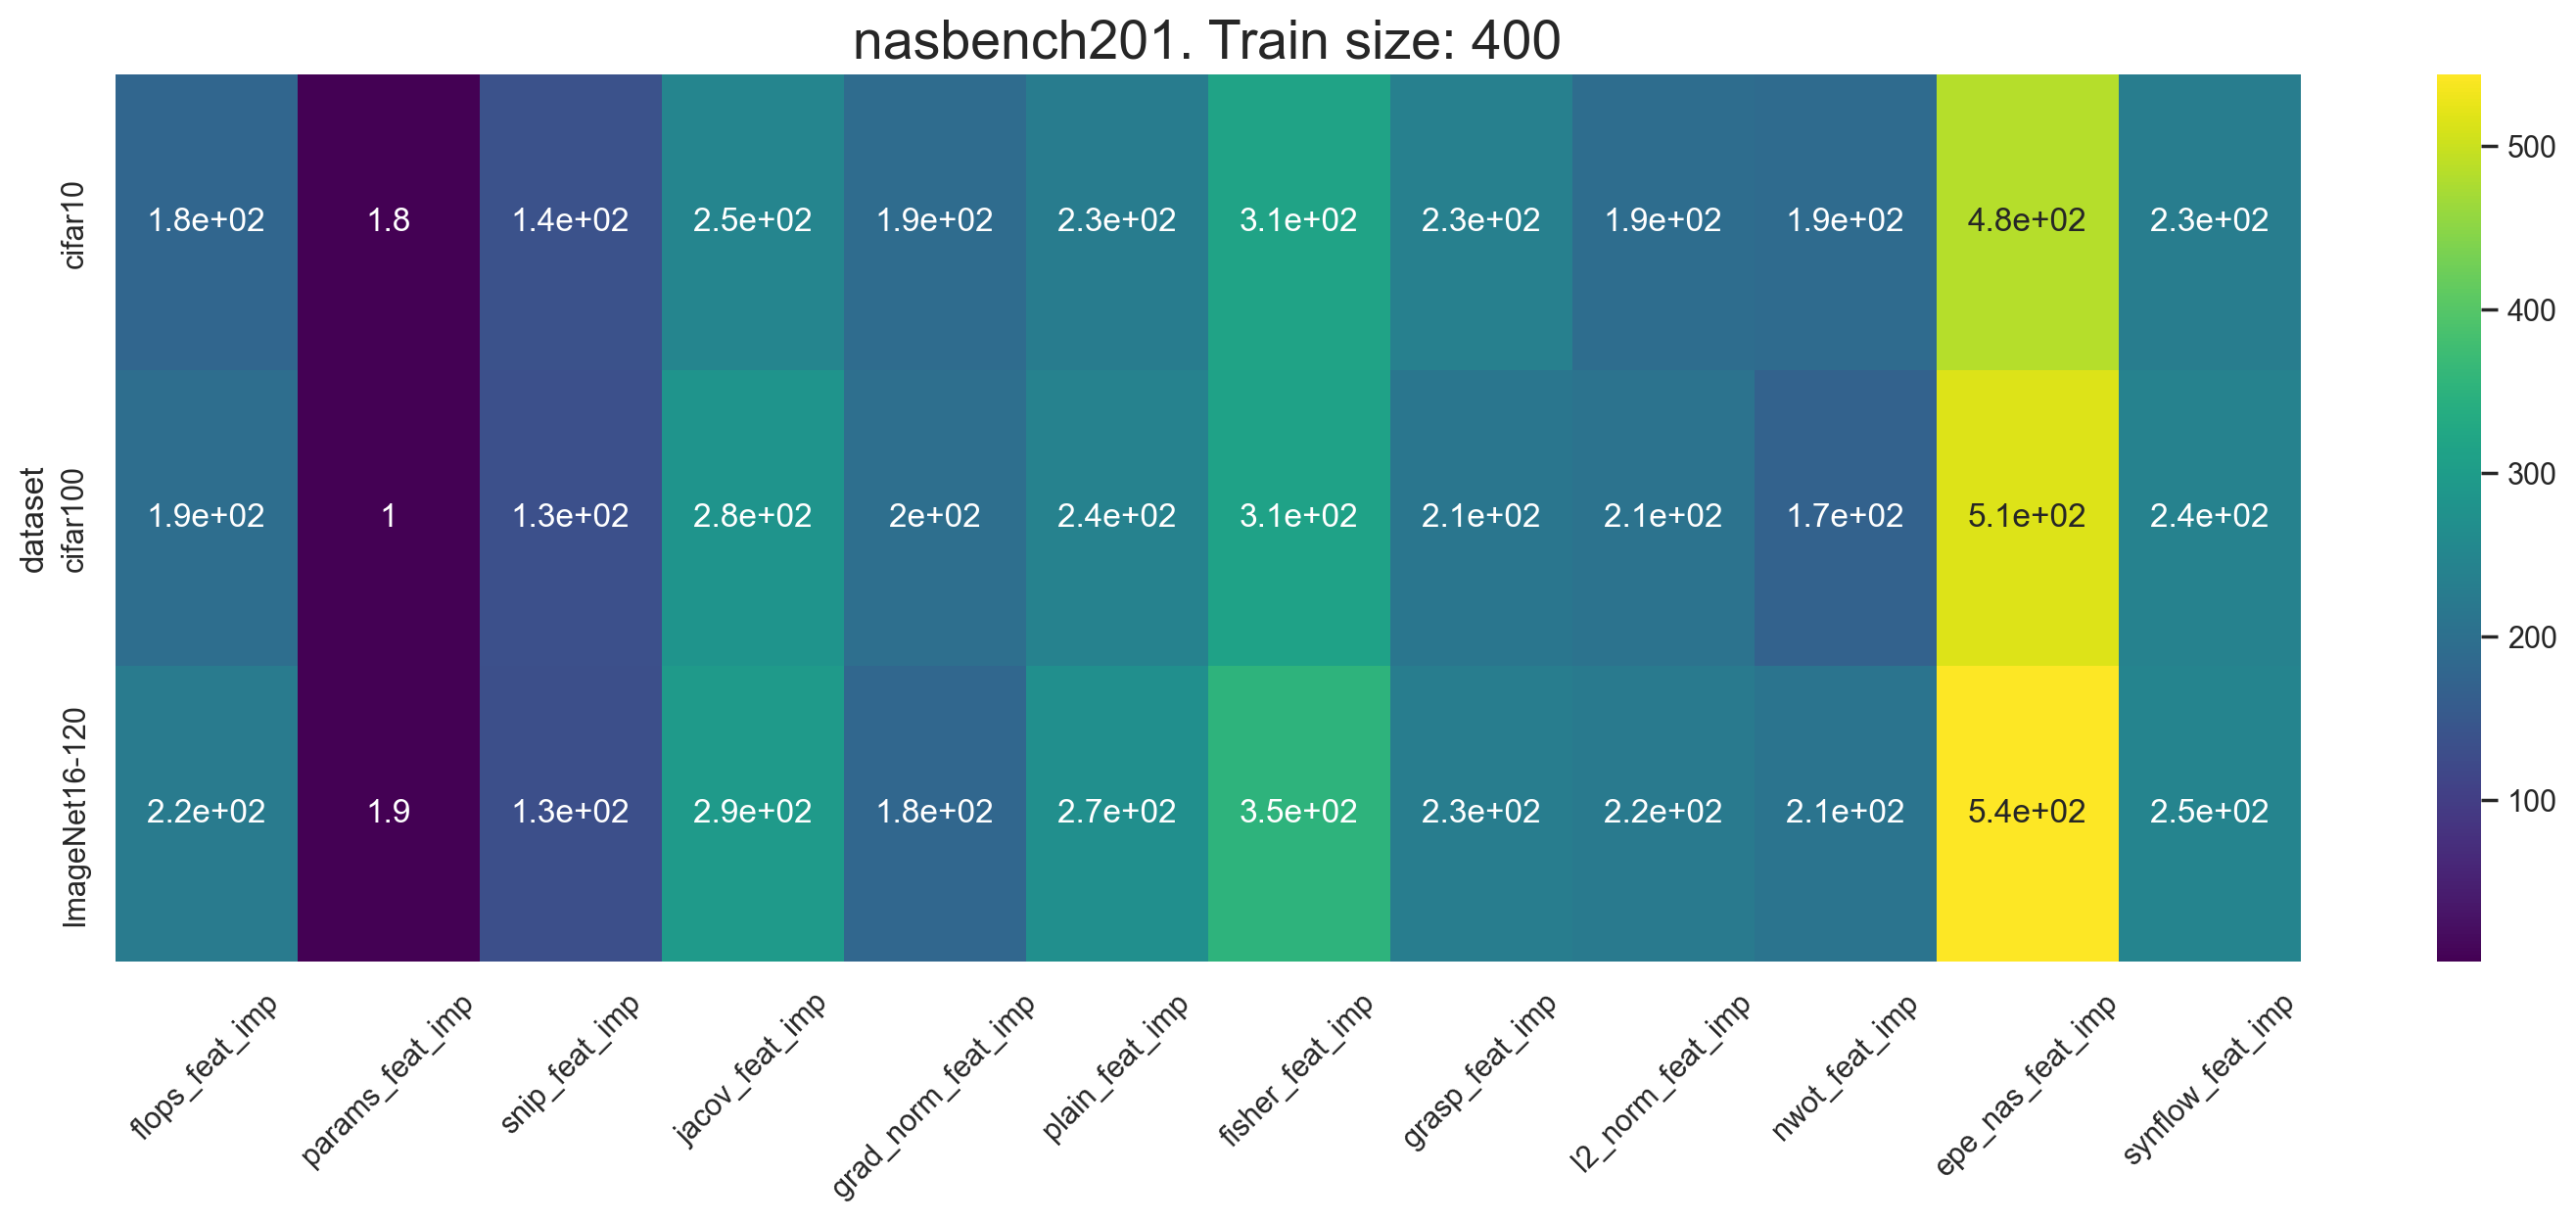

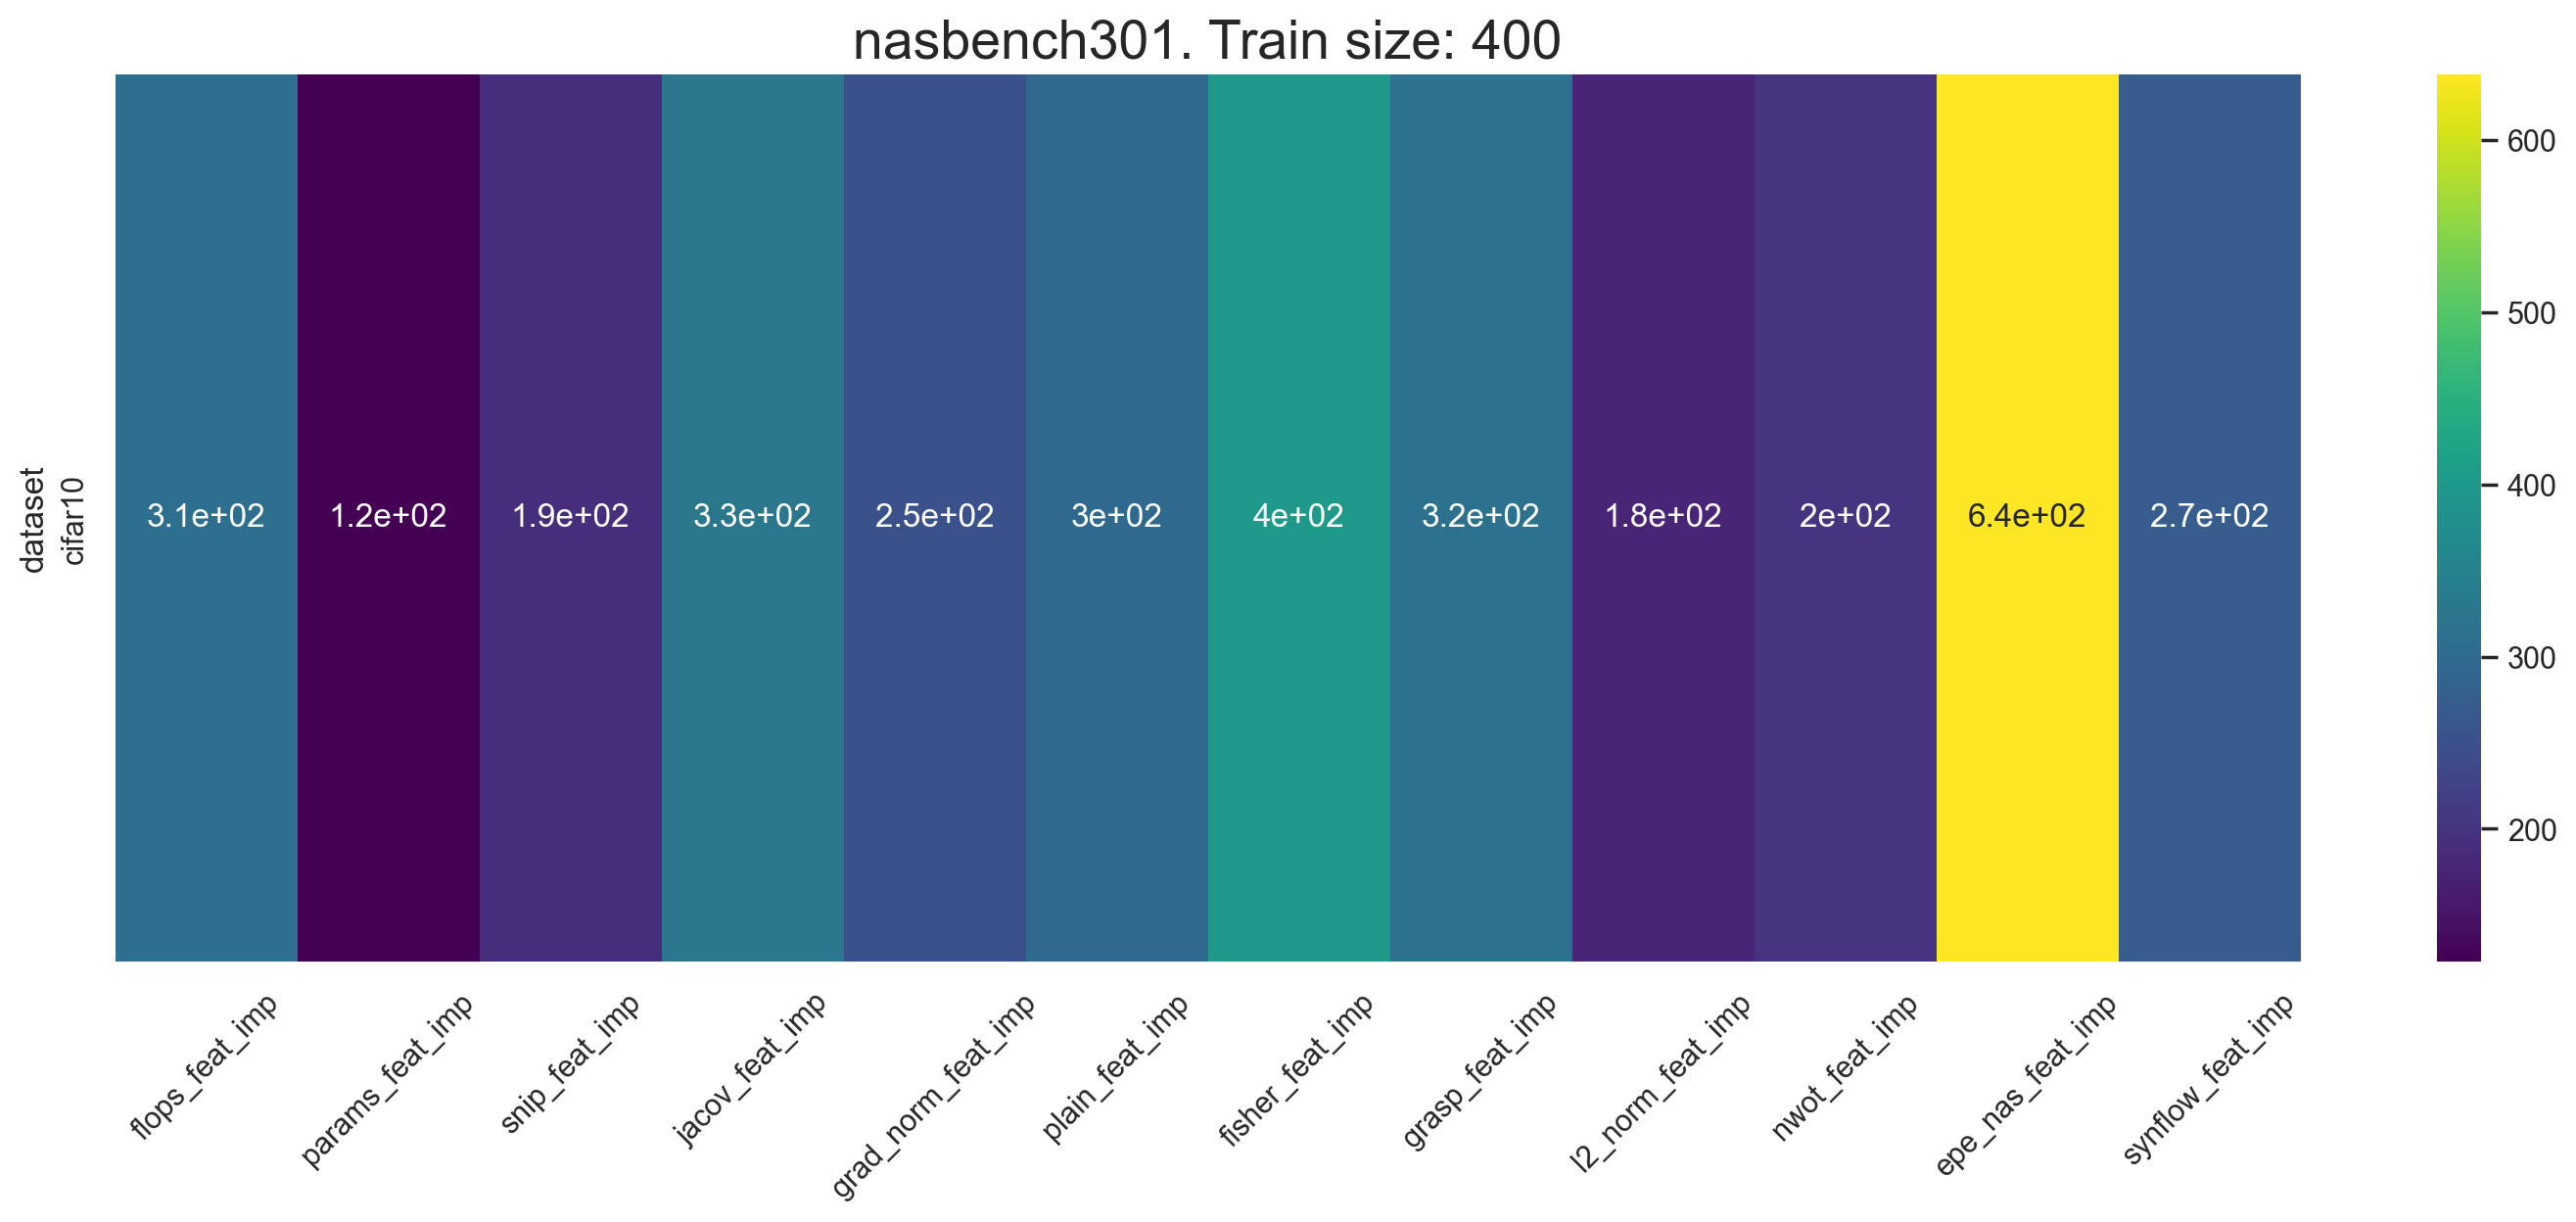

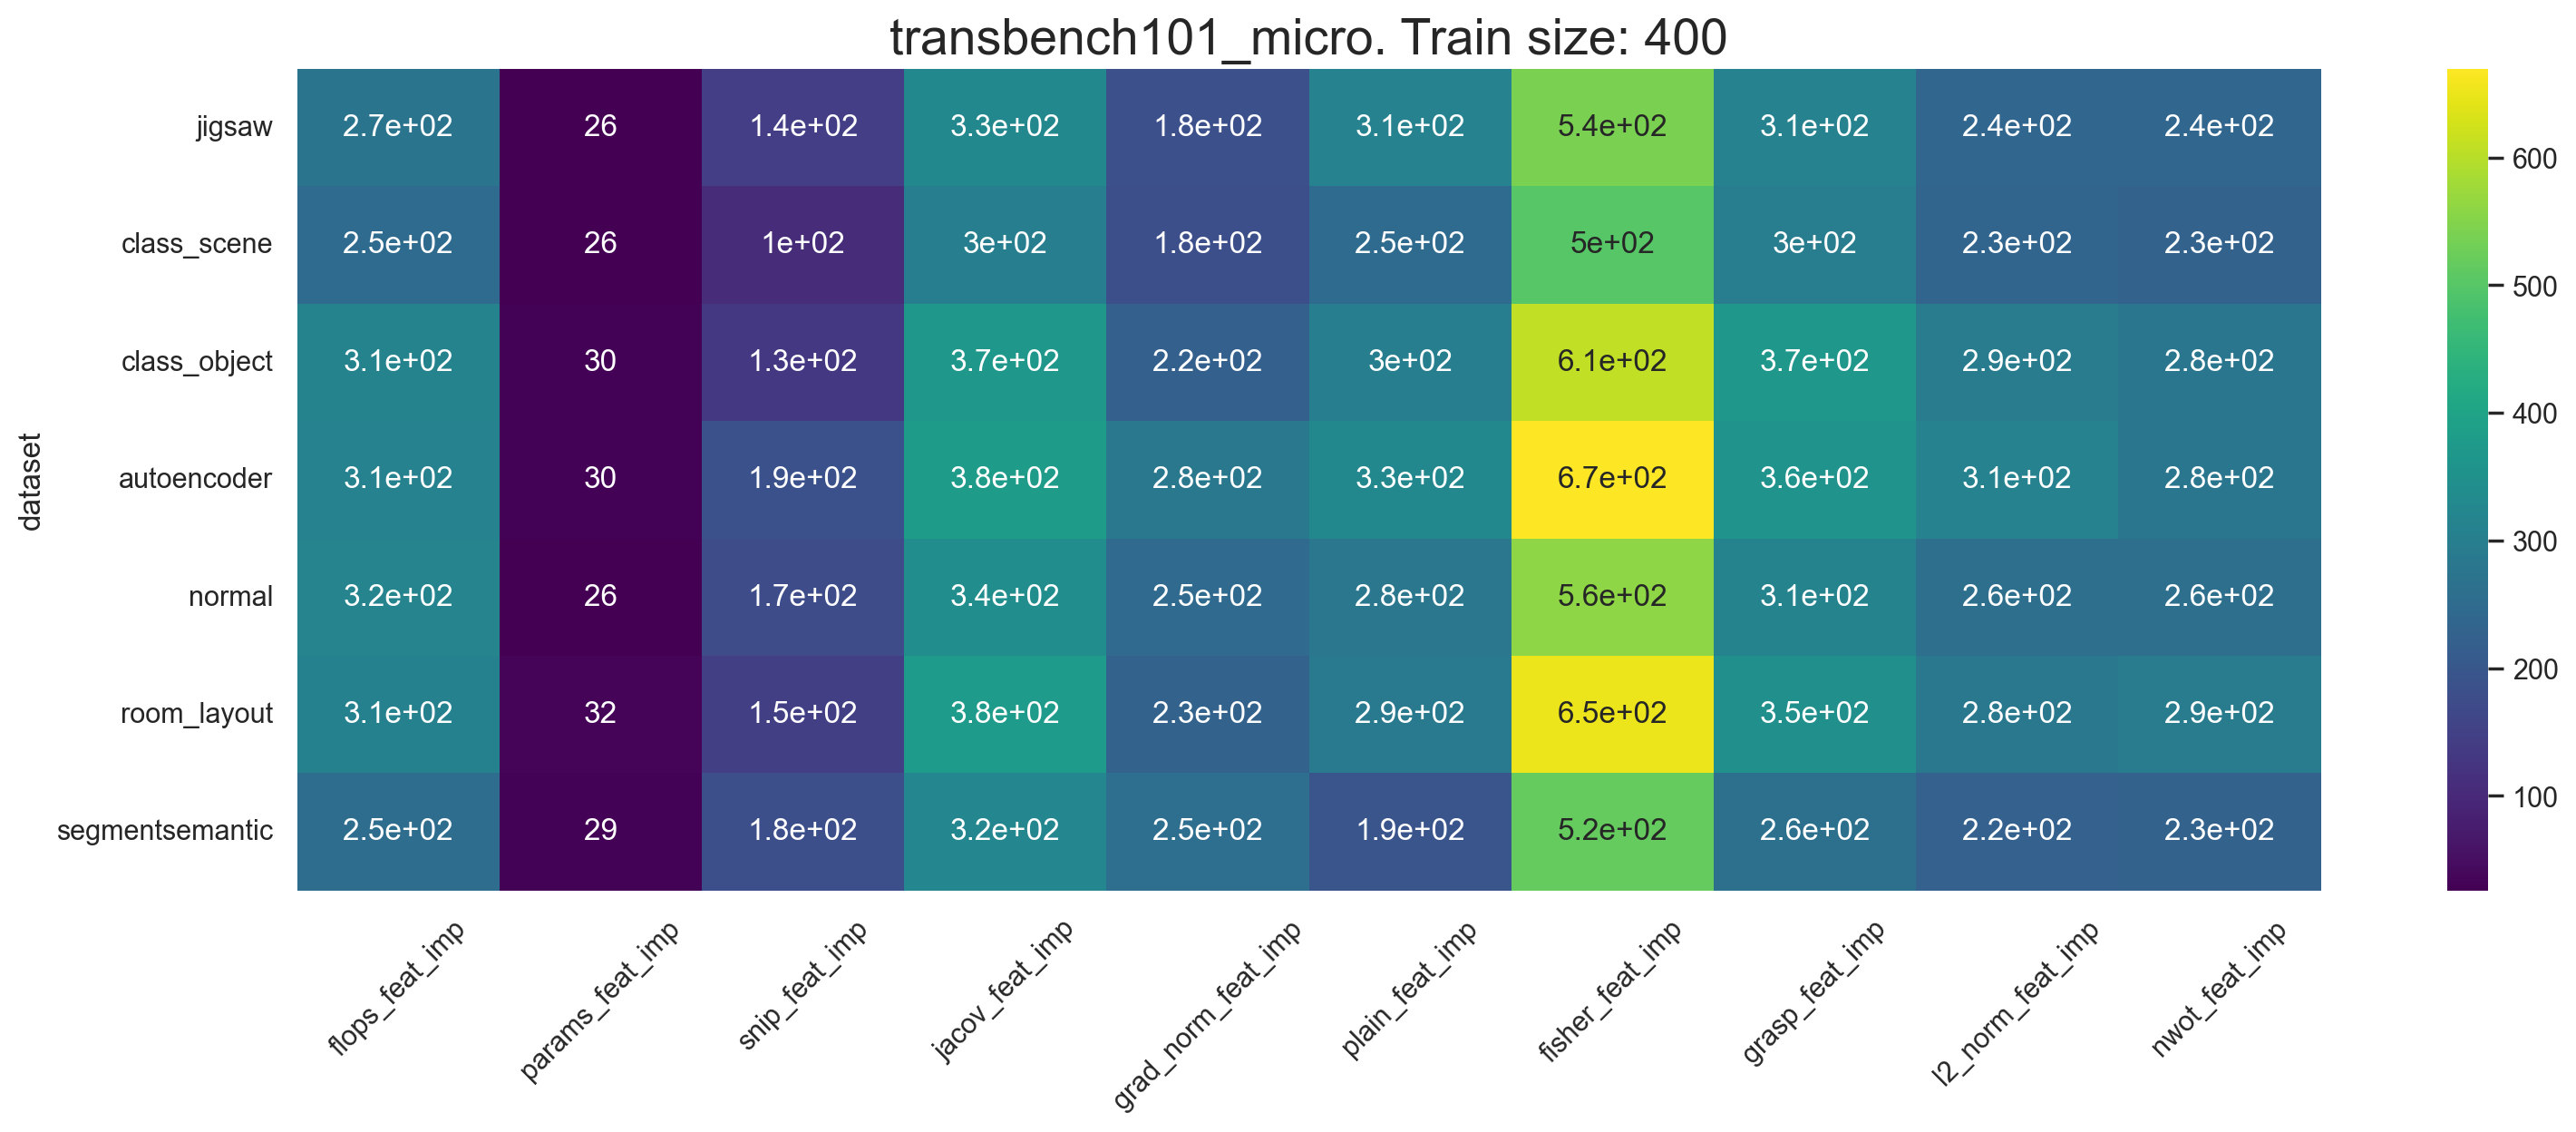

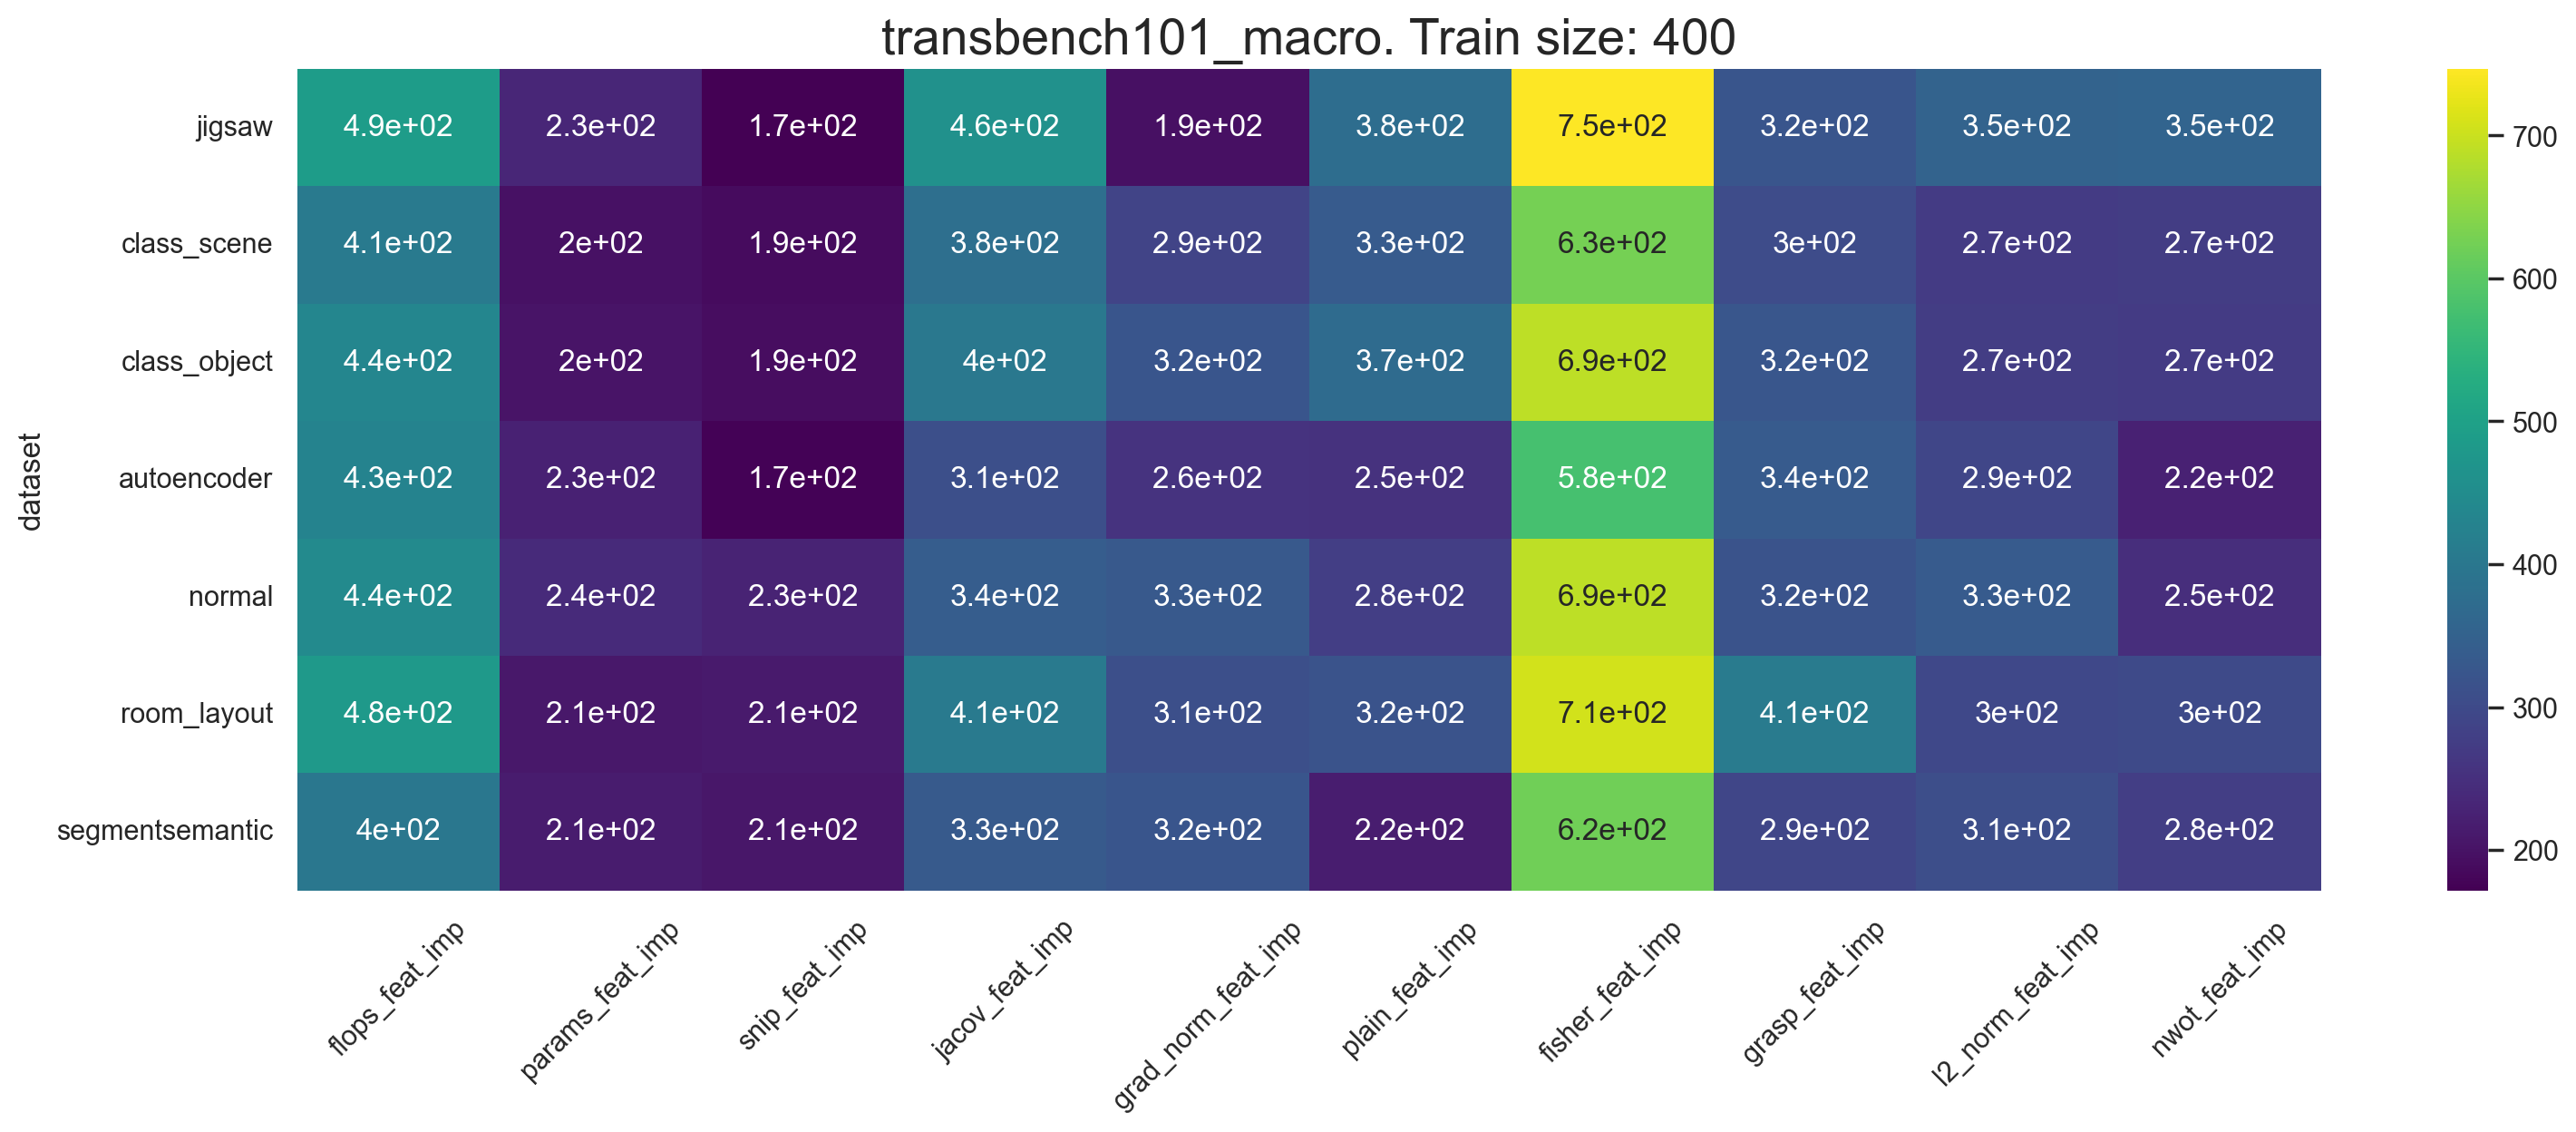

In [13]:
for search_space in BENCHMARKS.keys():
    for train_size in train_sizes:
        plot_feature_importance_heatmap(df, search_space, train_size=train_size)


In [14]:
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar10', train_sizes[:7], 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'cifar100', train_sizes[:7], 'spearman', color='grey')
# plot_train_sizes_vs_metric(df, 'nasbench201', 'ImageNet16-120', train_sizes[:7], 'spearman', color='grey')